In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import scipy.stats as stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

Adiciona caminho do dataset

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
dataset['populacao'].dtype

dtype('float64')

In [8]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [9]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [ ]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

In [ ]:
dataset['Porte'] = dataset['populacao'].apply(porte)

In [ ]:
dataset

Filtro

In [ ]:
dataset = dataset[dataset['Porte'] == 'Médio Porte']

In [ ]:
dataset

,Unnamed: 0,Data,Qtd. internacoes,Quadrimestre,UF,Município,Data completa,cd_mun_res,ano_obito,populacao,taxa_internacao,Porte
5,35,201001,249,1,AC,CRUZEIRO DO SUL,2010-01-01,120020.0,2010,81907.0,3.040033,Médio Porte
36,869,201001,54,1,AL,CAMPO ALEGRE,2010-01-01,270140.0,2010,52041.0,1.037643,Médio Porte
45,1011,201001,55,1,AL,CORURIPE,2010-01-01,270230.0,2010,53387.0,1.030213,Médio Porte
88,2707,201001,64,1,AL,PALMEIRA DOS ÍNDIOS,2010-01-01,270630.0,2010,72064.0,0.888099,Médio Porte
94,2839,201001,138,1,AL,PENEDO,2010-01-01,270670.0,2010,61834.0,2.231782,Médio Porte
...,...,...,...,...,...,...,...,...,...,...,...,...
801934,25966655,202112,43,3,SP,VINHEDO,2021-12-01,355670.0,2021,81516.0,0.527504,Médio Porte
801939,25966902,202112,79,3,SP,VOTUPORANGA,2021-12-01,355710.0,2021,96106.0,0.822009,Médio Porte
801999,25967570,202112,27,3,TO,GURUPI,2021-12-01,170950.0,2021,88428.0,0.305333,Médio Porte
802033,25968002,202112,26,3,TO,PARAÍSO DO TOCANTINS,2021-12-01,171610.0,2021,52521.0,0.495040,Médio Porte


In [ ]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-14-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [ ]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [ ]:
time_series = time_series[:'2019-12-31']

#Decomposição da série

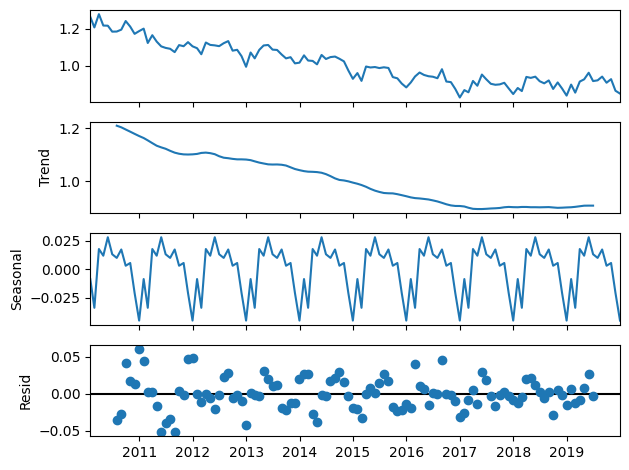

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time_series, model='aditive')
result.plot()
plt.show()

#Teste de Estacionariedade


In [ ]:
X = time_series['taxa_internacao']
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: -2.788820
Valor de P: 0.059889
Valores Críticos:
	1%: -3.493
	5%: -2.889
	10%: -2.581


#Tornando a série estacionária (Diferenciação)

<Axes: xlabel='Data completa'>

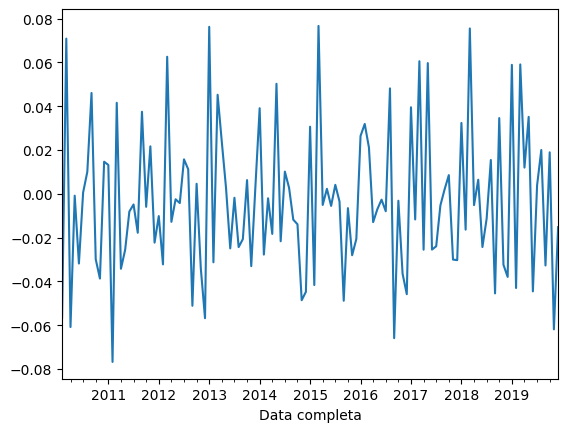

In [ ]:
xdiff = X.diff()
xdiff = xdiff.dropna()
xlabel='Data'
xdiff.plot()

In [ ]:
result = adfuller(xdiff)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: -3.873897
Valor de P: 0.002236
Valores Críticos:
	1%: -3.493
	5%: -2.889
	10%: -2.581


#Suavização Exponencial Simples


In [ ]:
X_base = X[:'2018-12-31']

In [ ]:
X_base

,taxa_internacao
Data completa,
2010-01-31,1.262302
2010-02-28,1.205797
2010-03-31,1.276683
2010-04-30,1.215884
2010-05-31,1.215052
...,...
2018-08-31,0.922505
2018-09-30,0.877068
2018-10-31,0.911678


In [ ]:
suavizacao_exponencial_fit = SimpleExpSmoothing(X_base).fit(smoothing_level=0.2,optimized=False) #alpha = 0.2: 20% de peso para as observações mais recentes, optimazed: acha um valor otimizado para o smoothing_level
suavizacao_exponencial_future_forecast = suavizacao_exponencial_fit.forecast(12)

In [ ]:
suavizacao_exponencial_future_forecast

,0
2019-01-31,0.889873
2019-02-28,0.889873
2019-03-31,0.889873
2019-04-30,0.889873
2019-05-31,0.889873
2019-06-30,0.889873
2019-07-31,0.889873
2019-08-31,0.889873
2019-09-30,0.889873
2019-10-31,0.889873


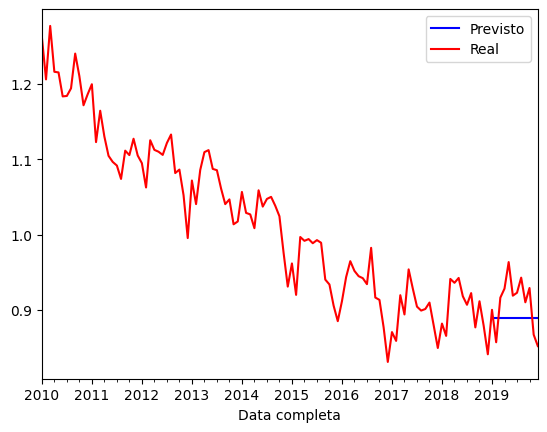

In [ ]:
suavizacao_exponencial_future_forecast.plot(marker='', color='blue', legend=True, label = 'Previsto')
X.plot(marker='',  color='red', label = 'Real', legend = True)
plt.show()

In [ ]:

# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = suavizacao_exponencial_future_forecast  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

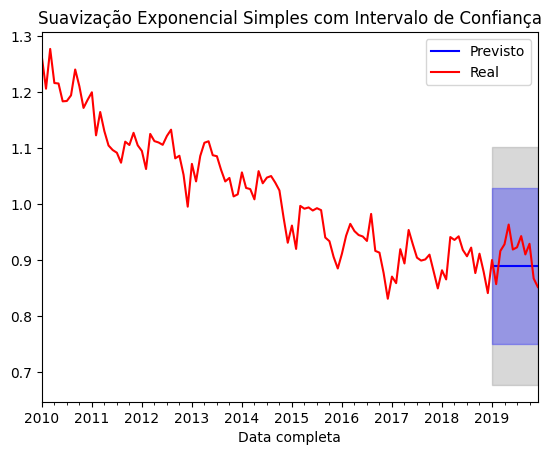

In [ ]:
suavizacao_exponencial_future_forecast.plot(marker='', color='blue', legend=True, label = 'Previsto')
X.plot(marker='',  color='red', label = 'Real', legend = True)

# Plotar intervalo de confiança
plt.fill_between(suavizacao_exponencial_future_forecast.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(suavizacao_exponencial_future_forecast.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

plt.title('Suavização Exponencial Simples com Intervalo de Confiança')

plt.show()

In [ ]:
real = X['2019-01-01':]

In [ ]:
real

,taxa_internacao
Data completa,
2019-01-31,0.900318
2019-02-28,0.857349
2019-03-31,0.916452
2019-04-30,0.928450
2019-05-31,0.963617
2019-06-30,0.919100
2019-07-31,0.922979
2019-08-31,0.943013
2019-09-30,0.910317


In [ ]:
mean_absolute_error(real, suavizacao_exponencial_future_forecast)

0.03477354921480095

In [ ]:
np.sqrt(mean_squared_error(real, suavizacao_exponencial_future_forecast))

0.03815064085227185

In [ ]:
mean_absolute_percentage_error(real, suavizacao_exponencial_future_forecast)

0.03796222615941965

In [ ]:
real

,taxa_internacao
Data completa,
2019-01-31,0.900318
2019-02-28,0.857349
2019-03-31,0.916452
2019-04-30,0.928450
2019-05-31,0.963617
2019-06-30,0.919100
2019-07-31,0.922979
2019-08-31,0.943013
2019-09-30,0.910317


#SARIMA


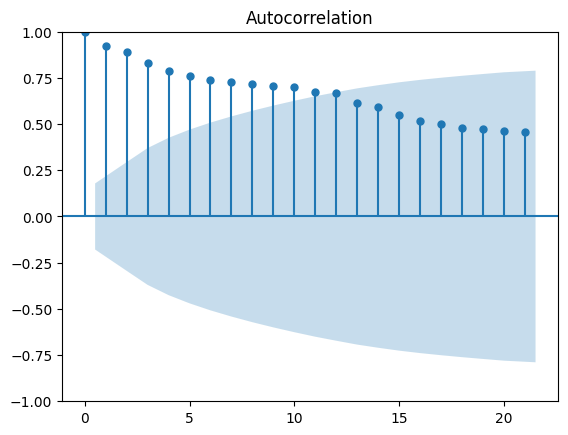

In [ ]:
plot_acf(X)
plt.show()

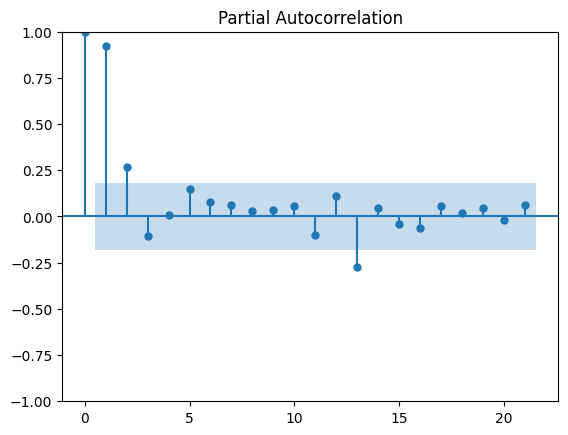

In [ ]:
plot_pacf(X, method='ywm')
plt.show()

In [ ]:
acorr_ljungbox(X, lags=[24])

,lb_stat,lb_pvalue
24,1332.398322,1.377493e-266


In [ ]:
sarima_model = auto_arima(X,start_p=1, start_q=1,max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-476.872, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-432.580, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-463.895, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-472.906, Time=0.54 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-446.337, Time=0.41 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-475.526, Time=1.32 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-475.630, Time=2.24 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-471.642, Time=0.91 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-473.406, Time=9.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-471.554, Time=1.33 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-474.891, Time=2.30 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-474.593, Time=1.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-468.967, Time=0.91 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-473.920, Time=0.92 sec
 ARIMA(2,1,0)(0,1,1

In [ ]:
print(sarima_model.aic())

-478.8535872501002


In [ ]:
train = X.loc[:'2018-12-31']
test = X.loc['2019-01-01':]

In [ ]:
sarima_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [ ]:
sarima_future_forecast = sarima_model.predict(n_periods=12)

In [ ]:
sarima_future_forecast.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
sarima_future_forecast

,0
2019-01-31,0.876365
2019-02-28,0.865286
2019-03-31,0.926288
2019-04-30,0.915946
2019-05-31,0.936196
2019-06-30,0.918205
2019-07-31,0.908828
2019-08-31,0.921793
2019-09-30,0.890012
2019-10-31,0.907020


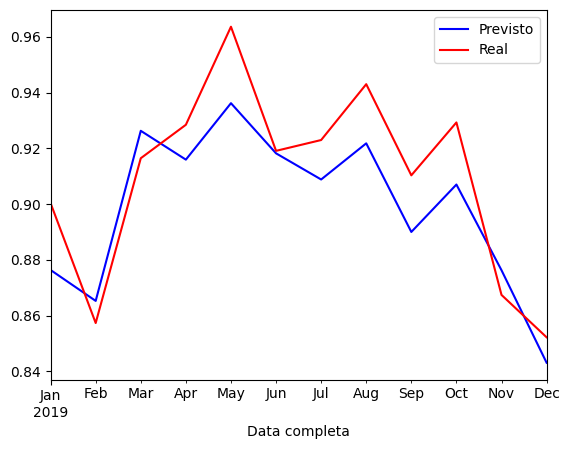

In [ ]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

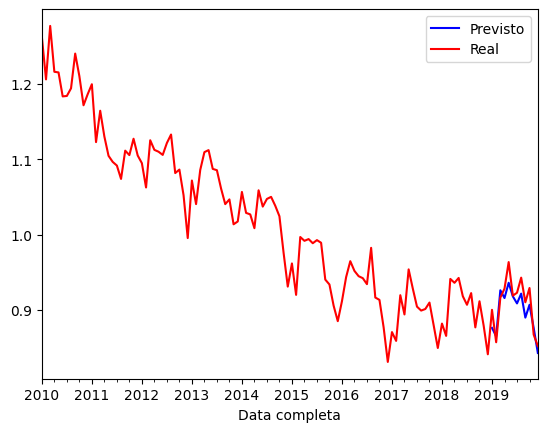

In [ ]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [ ]:

# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = sarima_future_forecast  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [ ]:
sarima_future_forecast.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

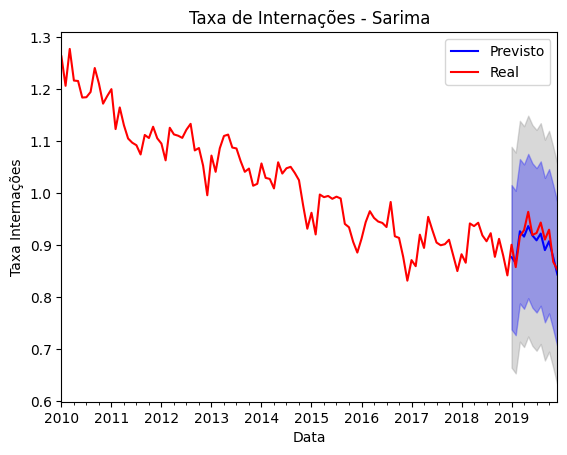

In [ ]:

sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.title('Taxa de Internações - Sarima')
plt.ylabel('Taxa Internações')
plt.xlabel('Data')

plt.fill_between(sarima_future_forecast.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(sarima_future_forecast.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

In [ ]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,sarima_future_forecast)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,sarima_future_forecast)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,sarima_future_forecast)
print(f'MAPE: {mape}')

TU = theil_u2(test, sarima_future_forecast)
print(f'TU: {TU}')

MAE: 0.014872434419178173
MSE: 0.00028024259094744933
RMSE: 0.016740447752298902
MAPE: 0.016209133051414467
TU: 0.4324495467655034


In [ ]:
model_fit = sarima_model.fit(train)

In [ ]:
durbin_watson(model_fit.resid())

1.298304398783347

#ARIMA

In [ ]:
arima_model = auto_arima(X,
                         start_p=1, start_q=1,
                         max_p=6, max_q=6,
                         seasonal=False,  # Definindo como False para um modelo ARIMA
                         d=1, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-481.788, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-466.704, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-483.239, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-479.940, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-467.450, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-481.939, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-479.847, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-482.717, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.977 seconds


In [ ]:
arima_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
future_forecast_arima = arima_model.predict(n_periods=12)

In [ ]:
future_forecast_arima.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

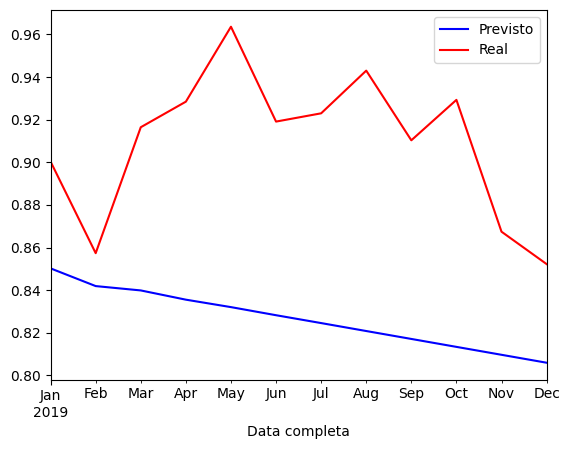

In [ ]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

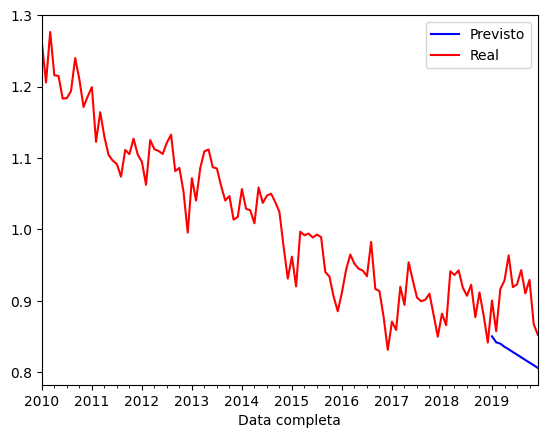

In [ ]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [ ]:
# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = future_forecast_arima  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [ ]:
future_forecast_arima

,0
2019-01-31,0.850208
2019-02-28,0.841904
2019-03-31,0.839864
2019-04-30,0.835530
2019-05-31,0.832036
2019-06-30,0.828234
2019-07-31,0.824545
2019-08-31,0.820815
2019-09-30,0.817099
2019-10-31,0.813379


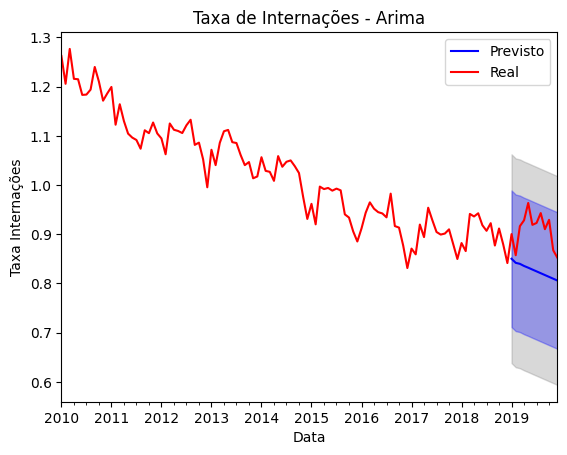

In [ ]:

future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.title('Taxa de Internações - Arima')
plt.ylabel('Taxa Internações')
plt.xlabel('Data')

plt.fill_between(future_forecast_arima.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(future_forecast_arima.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

In [ ]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,future_forecast_arima)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,future_forecast_arima)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,future_forecast_arima)
print(f'MAPE: {mape}')

TU = theil_u2(test, future_forecast_arima)
print(f'TU: {TU}')

MAE: 0.08261117889143238
MSE: 0.007920549135207141
RMSE: 0.08899746701568051
MAPE: 0.08975159515140857
TU: 2.4888253412173196


In [ ]:
model_fit = arima_model.fit(train)

In [ ]:
durbin_watson(model_fit.resid())

1.133099896315421

In [ ]:
!pip freeze > requirements.txt